In [1]:
# To start, we install Rasterio, a Python module for interacting with gridded spatial data
!pip install rasterio

     |▏                               | 71 kB 3.0 MB/s eta 0:00:07

     |█                               | 563 kB 3.2 MB/s eta 0:00:06

     |█▉                              | 1.1 MB 3.2 MB/s eta 0:00:06

     |███▎                            | 1.8 MB 3.2 MB/s eta 0:00:06

     |█████                           | 2.8 MB 3.2 MB/s eta 0:00:05

     |███████▏                        | 4.1 MB 3.2 MB/s eta 0:00:05

     |█████████▋                      | 5.5 MB 3.2 MB/s eta 0:00:04

     |████████████▉                   | 7.3 MB 3.2 MB/s eta 0:00:04

     |████████████████▊               | 9.5 MB 3.2 MB/s eta 0:00:03

     |█████████████████████▌          | 12.3 MB 3.2 MB/s eta 0:00:02

     |███████████████████████████▍    | 15.6 MB 3.2 MB/s eta 0:00:01

     |████████████████████████████████| 18.2 MB 3.2 MB/s eta 0:00:01

     |████████████████████████████████| 18.2 MB 3.2 MB/s 


# Reading and manipulating tiled GeoTIFF datasets

This notebook shows how to perform simple calculations with a GeoTIFF dataset using XArray and Dask. We load and rescale a Landsat 8 image and compute NDVI (Normalized difference vegetation index). This can be used to distinguish green vegetation from areas of bare land or water.

We'll use an image of the Denver, USA area taken in July 2018.

![RGB image](https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_thumb_small.jpg)

## Download data

First, we download the dataset. We are using an image from the cloud-hosted [Landsat 8 public dataset](https://landsatonaws.com/) and each band is available as a separate GeoTIFF file.

In [2]:
import os
import json
import rasterio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nir_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B5.TIF'
red_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_B4.TIF'
mtl_filename = 'https://landsat-pds.s3.amazonaws.com/c1/L8/033/033/LC08_L1TP_033033_20180706_20180717_01_T1/LC08_L1TP_033033_20180706_20180717_01_T1_MTL.json'

In [4]:
def download_file(in_filename, out_filename):
    if not os.path.exists(out_filename):
        print("Downloading", in_filename)
        response = requests.get(in_filename)
        with open(out_filename, 'wb') as f:
            f.write(response.content)

In [5]:
download_file(nir_filename, 'nir.tif')
download_file(red_filename, 'red.tif')
download_file(mtl_filename, 'meta.json')

## Check image metadata

Let's see if the image is tiled so we can select a chunk size.

In [6]:
img = rasterio.open('red.tif')
print(img.is_tiled)

True


In [7]:
img.block_shapes

[(512, 512)]

The image has separate blocks for each band with block size 512 x 512. 

## Create XArray datasets

In [8]:
import xarray as xr
red = xr.open_rasterio('red.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
nir = xr.open_rasterio('nir.tif', chunks={'band': 1, 'x': 1024, 'y': 1024})
nir

<xarray.DataArray (band: 1, y: 7841, x: 7721)>
dask.array<open_rasterio-45e65e9aeda51f4e4f211f8448bdc9d0<this-array>, shape=(1, 7841, 7721), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.423e+06 4.423e+06 4.423e+06 ... 4.188e+06 4.188e+06
  * x        (x) float64 4.134e+05 4.134e+05 4.135e+05 ... 6.45e+05 6.45e+05
Attributes:
    transform:      (30.0, 0.0, 413385.0, 0.0, -30.0, 4423215.0)
    crs:            +init=epsg:32613
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

Each dataset's data is a Dask array.

In [9]:
red.variable.data

dask.array<open_rasterio-b01931940fd869b5f16446fc589e8f33<this-array>, shape=(1, 7841, 7721), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

## Optional: create a Dask client

You can start a Dask client to monitor execution with the dashboard.

In [10]:
import dask
from dask.distributed import Client
client = Client(processes=False)
client

Client Scheduler: inproc://10.1.0.4/8945/1 Dashboard: http://10.1.0.4:8787/status,Cluster Workers: 1 Cores: 2 Memory: 7.29 GB


## Rescale bands using Landsat metadata

The Landsat Level 1 images are delivered in a quantized format. This has to be [converted to top-of-atmosphere reflectance](https://landsat.usgs.gov/using-usgs-landsat-8-product) using the provided metadata.

First we define convenience functions to load the rescaling factors and transform a dataset. The red band is band 4 and near infrared is band 5.

In [11]:
def load_scale_factors(filename, band_number):
    with open(filename) as f:
        metadata = json.load(f)
    M_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_MULT_BAND_{}'.format(band_number)]
    A_p = metadata['L1_METADATA_FILE'] \
                  ['RADIOMETRIC_RESCALING'] \
                  ['REFLECTANCE_ADD_BAND_{}'.format(band_number)]
    return M_p, A_p

In [12]:
def calculate_reflectance(ds, band_number, metafile='meta.json'):
    M_p, A_p = load_scale_factors(metafile, band_number)
    toa = M_p * ds + A_p
    return toa

In [13]:
red_toa = calculate_reflectance(red, band_number=4)
nir_toa = calculate_reflectance(nir, band_number=5)

Because the transformation is composed of arithmetic operations, execution is delayed and the operations are parallelized automatically.

In [14]:
print(red_toa.variable.data)

dask.array<add, shape=(1, 7841, 7721), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>


The resulting image has floating point data with magnitudes appropriate to reflectance. This can be checked by computing the range of values in an image:

In [15]:
red_max, red_min, red_mean = dask.compute(
    red_toa.max(dim=['x', 'y']), 
    red_toa.min(dim=['x', 'y']),
    red_toa.mean(dim=['x', 'y'])
)
print(red_max.item())
print(red_min.item())
print(red_mean.item())

1.2107
-0.1
0.05921340355007137


## Calculate and display NDVI

Now that we have the image as reflectance values, we are ready to compute NDVI.

$$
NDVI = \frac{NIR - Red}{NIR + Red}
$$

This highlights areas of healthy vegetation with high NDVI values, which appear as green in the image below.

In [16]:
ndvi = (nir_toa - red_toa) / (nir_toa + red_toa)

In [17]:
ndvi2d = ndvi.squeeze()

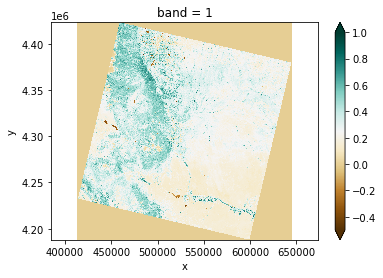

In [18]:
plt.figure()
im = ndvi2d.compute().plot.imshow(cmap='BrBG', vmin=-0.5, vmax=1)
plt.axis('equal')
plt.show()